In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.manifold import TSNE

# Load dataset
def load_data(file_path):
    """Loads text data from a file."""
    with open(file_path, 'r') as file:
        text = file.read()
    return text

# Clean text
def clean_text(text):
    """Cleans the text by removing URLs, special characters, and converting to lowercase."""
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub('[^a-zA-Z0-9 \.]', '', text)  # Remove special characters
    text = text.lower()  # Convert text to lowercase
    return text

# Load and clean data
file_path = '/kaggle/input/sherlock1/sherlock.txt'  # Replace with your dataset path
text = load_data(file_path)
cleaned_text = clean_text(text)
words = cleaned_text.split()

# Create vocabulary
unique_words = sorted(set(words))
stoi = {s: i + 1 for i, s in enumerate(unique_words)}  # String to index
itos = {i: s for s, i in stoi.items()}  # Index to string

# Print vocabulary size
print(f"Vocabulary Size: {len(stoi)}")

# Additional steps, like creating training data or embedding visualizations, could go here.


Vocabulary Size: 16813


In [2]:
import torch
torch.cuda.is_available()  # Returns True if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
import torch

# Assuming you've already defined stoi, itos, and words

block_size = 5  # Number of words to predict the next one
X, Y = [], []

for i in range(len(words) - block_size):
    context = words[i:i + block_size]  # Get the context of words
    next_word = words[i + block_size]  # Get the next word
    X.append([stoi[w] for w in context])  # Append the context as indices
    Y.append(stoi[next_word])  # Append the next word index

# Convert to tensors
X = torch.tensor(X)
Y = torch.tensor(Y)

# Move tensors to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = X.to(device)
Y = Y.to(device)

# Print the input-output pairs (you can do this on CPU)
for i in range(len(X)):
    context_words = [itos[idx.item()] for idx in X[i].cpu()]  # Convert indices back to words (move to CPU for printing)
    next_word = itos[Y[i].item()]  # Convert index to word
    print(f"{' '.join(context_words)} --->  {next_word}")


the project gutenberg ebook of --->  the
project gutenberg ebook of the --->  adventures
gutenberg ebook of the adventures --->  of
ebook of the adventures of --->  sherlock
of the adventures of sherlock --->  holmesby
the adventures of sherlock holmesby --->  arthur
adventures of sherlock holmesby arthur --->  conan
of sherlock holmesby arthur conan --->  doylethis
sherlock holmesby arthur conan doylethis --->  ebook
holmesby arthur conan doylethis ebook --->  is
arthur conan doylethis ebook is --->  for
conan doylethis ebook is for --->  the
doylethis ebook is for the --->  use
ebook is for the use --->  of
is for the use of --->  anyone
for the use of anyone --->  anywhere
the use of anyone anywhere --->  in
use of anyone anywhere in --->  the
of anyone anywhere in the --->  united
anyone anywhere in the united --->  states
anywhere in the united states --->  andmost
in the united states andmost --->  other
the united states andmost other --->  parts
united states andmost other part

In [4]:
class NextWordMLP(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_size):
        super(NextWordMLP, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)  # Flatten the input
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

# Initialize model
model_relu_64_5 = NextWordMLP(len(stoi) + 1, emb_dim=64, hidden_size=1024).to(device)


In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 1: Select a subset of words (for example, 100 words)
selected_words = [
    "detect", "discover", "hide", "expose", "appear", "vanish",
    "observe", "notice", "truth", "lie", "crime", "justice",
    "clue", "evidence", "suspect", "accuse", "mystery", "solution",
    "search", "find", "silent", "speak", "solve", "unravel",
    "conceal", "reveal", "doubt", "certainty", "question", "answer",
    "sherlock", "watson", "holmes", "baker", "london", "night",
    "door", "case", "strange", "letter", "fear", "mind",
    "fact", "story", "secret", "danger", "friend", "enemy",
    "plan", "proof"
]
 # Add more as needed
selected_indices = [stoi[word] for word in selected_words if word in stoi]

# Step 2: Get embeddings before training
with torch.no_grad():
    model_relu_64_5.eval()
    embeddings_before = model_relu_64_5.emb(torch.tensor(selected_indices).to(device)).cpu().numpy()

In [6]:
torch.cuda.empty_cache()

In [9]:
import torch
import torch.nn as nn
import time

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
emb_dim = 64  # Embedding dimension for words
hidden_size = 1024  # Size of hidden layer
block_size = 5 # Context length (number of words to predict the next one)
vocab_size = len(stoi)  # Size of the vocabulary
batch_size = 1500
print_every = 50
elapsed_time = []

# Initialize model, loss function, and optimizer
model_RELu_64_5 = NextWordMLP(vocab_size + 1, emb_dim=emb_dim, hidden_size=hidden_size).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model_RELu_64_5.parameters(), lr=0.01)

# Move data to the GPU
X = X.to(device)
Y = Y.to(device)

# Training loop
for epoch in range(800):  # Loop for specified epochs
    
    model_RELu_64_5.train()  # Set model to training mode

    # Mini-batch processing
    for i in range(0, X.shape[0], batch_size):
        x_batch = X[i:i + batch_size].to(device)  # Get the batch of input sequences
        y_batch = Y[i:i + batch_size].to(device)  # Get the batch of next word labels

        # Forward pass: predict the next word
        y_pred = model_RELu_64_5(x_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)

        # Clear previous gradients
        opt.zero_grad()

        # Backpropagation: compute gradients
        loss.backward()

        # Update model parameters using optimizer
        opt.step()

        
    

    # Print loss at intervals
    if epoch % print_every == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

print("Training complete")


Epoch 0, Loss: 9.370649337768555
Epoch 50, Loss: 0.015995025634765625
Epoch 100, Loss: 0.013518542051315308
Epoch 150, Loss: 0.015868958085775375
Epoch 200, Loss: 0.01637735217809677
Epoch 250, Loss: 0.016161220148205757
Epoch 300, Loss: 0.016108527779579163
Epoch 350, Loss: 0.01423450093716383
Epoch 400, Loss: 0.013356277719140053
Epoch 450, Loss: 1.2112910747528076
Epoch 500, Loss: 0.09887617826461792
Epoch 550, Loss: 0.01275956816971302
Epoch 600, Loss: 0.01548041496425867
Epoch 650, Loss: 0.013580020517110825
Epoch 700, Loss: 0.015443358570337296
Epoch 750, Loss: 0.018087513744831085
Training complete


In [10]:
torch.save(model_RELu_64_5.state_dict(), 'model_relu_64_5.pth')


In [11]:
with torch.no_grad():
    embeddings_after = model_RELu_64_5.emb(torch.tensor(selected_indices).to(device)).cpu().numpy()

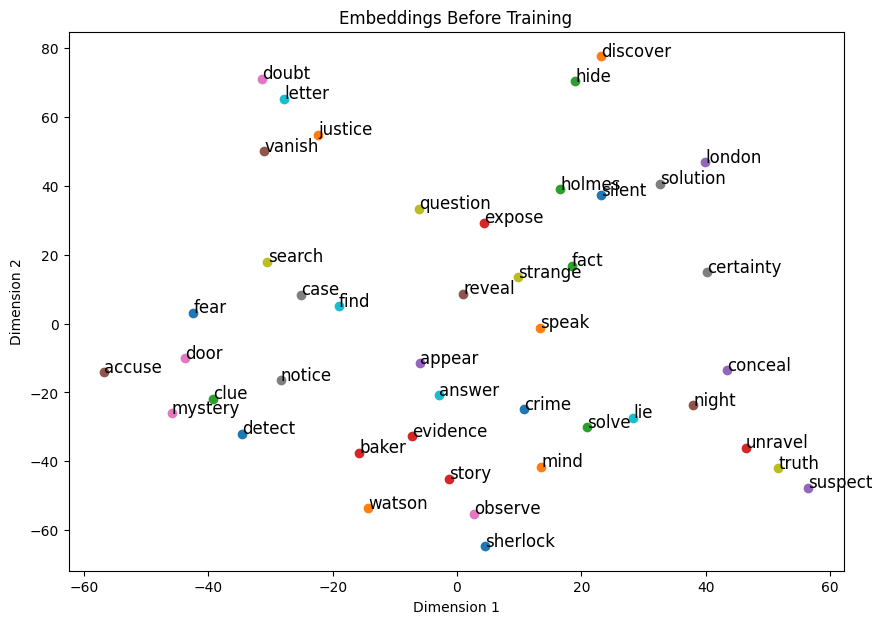

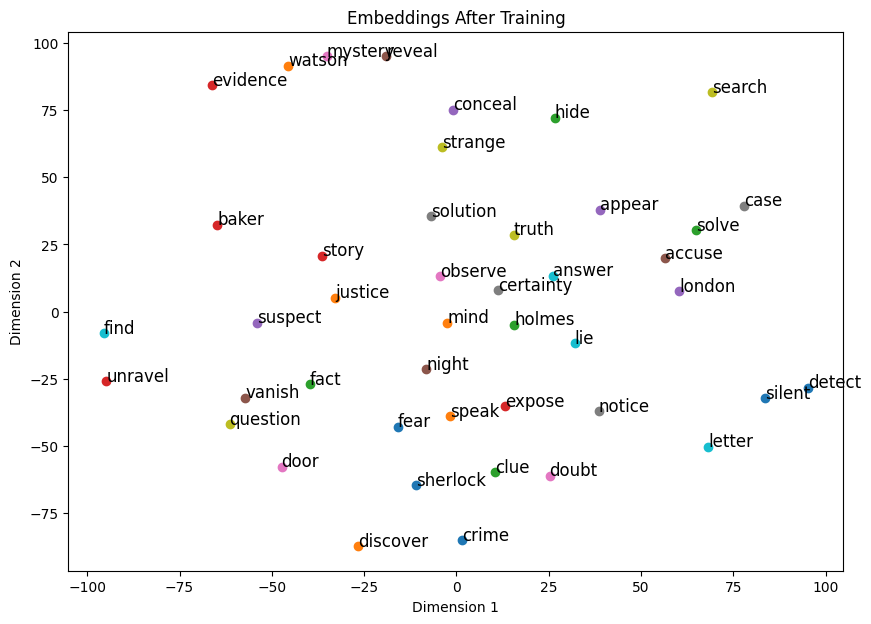

In [12]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming `embeddings_before` and `embeddings_after` are initialized
sample_size = len(embeddings_before)
perplexity = min(5, sample_size - 1)  # Set a smaller perplexity if needed

# Initialize t-SNE with the adjusted perplexity
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0)
embeddings_before_2d = tsne.fit_transform(embeddings_before)
embeddings_after_2d = tsne.fit_transform(embeddings_after)

# Adjust selected_words to match the length of embeddings
selected_words = selected_words[:len(embeddings_before_2d)]

# Plot function
def plot_embeddings(embeddings, words, title):
    plt.figure(figsize=(10, 7))
    for i, word in enumerate(words):
        x, y = embeddings[i]
        plt.scatter(x, y)
        plt.text(x + 0.02, y + 0.02, word, fontsize=12)
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

# Plot before and after training
plot_embeddings(embeddings_before_2d, selected_words, "Embeddings Before Training")
plot_embeddings(embeddings_after_2d, selected_words, "Embeddings After Training")


In [13]:
def predict_next_word(model, context_words, top_k=1):
    model.eval()  # Set the model to evaluation mode

    # Preprocess the input (convert words to indices)
    context_indices = [stoi[word] for word in context_words]

    # Convert to tensor and move to GPU
    context_tensor = torch.tensor(context_indices, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(context_tensor)
        probabilities = F.softmax(output, dim=-1)

        # Get the top_k predictions
        top_k_probs, top_k_indices = torch.topk(probabilities, top_k, dim=-1)

        predicted_words = [list(stoi.keys())[index.item()] for index in top_k_indices.squeeze()]

    return predicted_words

# Example usage
context = ["the", "cat", "is", "sitting", "on"]
predicted_word = predict_next_word(model_RELu_64_5, context, top_k=3)
print("Predicted next words:", predicted_word)

Predicted next words: ['theaffairs', 'a.', 'of.']
